Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [45]:
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [46]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [47]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [48]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [49]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [50]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
    )


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [51]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [52]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

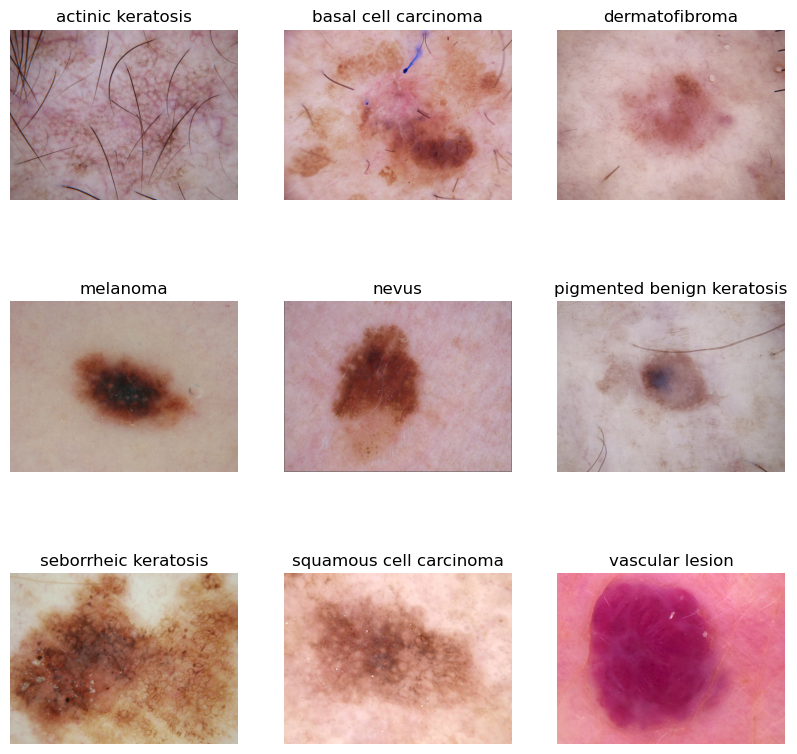

In [53]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [55]:
### Your code goes here
model=Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         


                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 45, 45, 32)        0         
                                                                 
 conv2d_14

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [56]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(
            optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [57]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

### Train the model

In [58]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/20


169/169 [==============================] - 109s 503ms/step - loss: 2.1970 - accuracy: 0.1441 - val_loss: 2.1860 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 2/20
169/169 [==============================] - 80s 471ms/step - loss: 2.1773 - accuracy: 0.1534 - val_loss: 2.1755 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 3/20
169/169 [==============================] - 86s 512ms/step - loss: 2.1231 - accuracy: 0.1908 - val_loss: 2.0620 - val_accuracy: 0.1923 - lr: 0.0010
Epoch 4/20
169/169 [==============================] - 85s 501ms/step - loss: 1.8723 - accuracy: 0.2793 - val_loss: 1.8627 - val_accuracy: 0.3170 - lr: 0.0010
Epoch 5/20
169/169 [==============================] - 84s 498ms/step - loss: 1.6607 - accuracy: 0.3733 - val_loss: 1.5631 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 6/20
169/169 [==============================] - 78s 462ms/step - loss: 1.5493 - accuracy: 0.4093 - val_loss: 1.5597 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 7/20
169/169 [==============================] - 94s 557m

### Visualizing training results

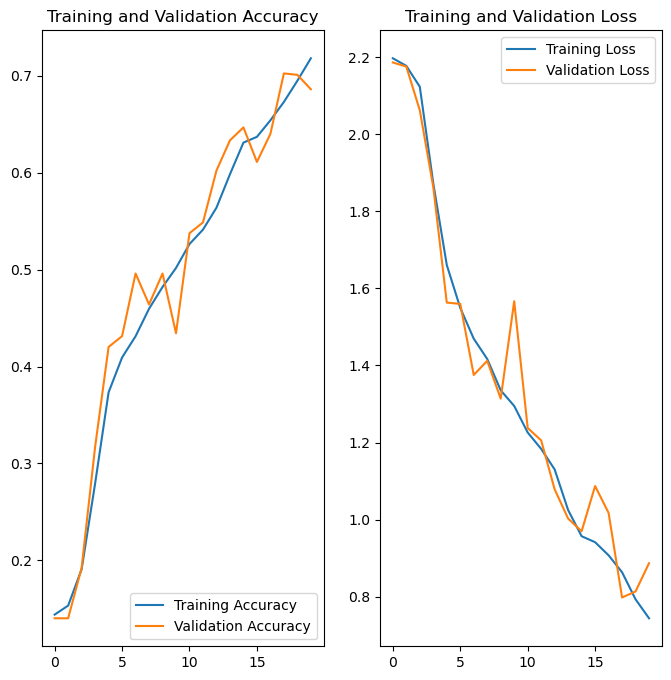

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

##### The model is underfitting

1. The Training accuracy and validation accuracy are almost same initially but accuracy is low which means it is underfitting
2. Training loss is very low, but validation loss is fluctuating.

Looking at this we can conclude that we need to work on the model to ensure better predicatibility

In [60]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

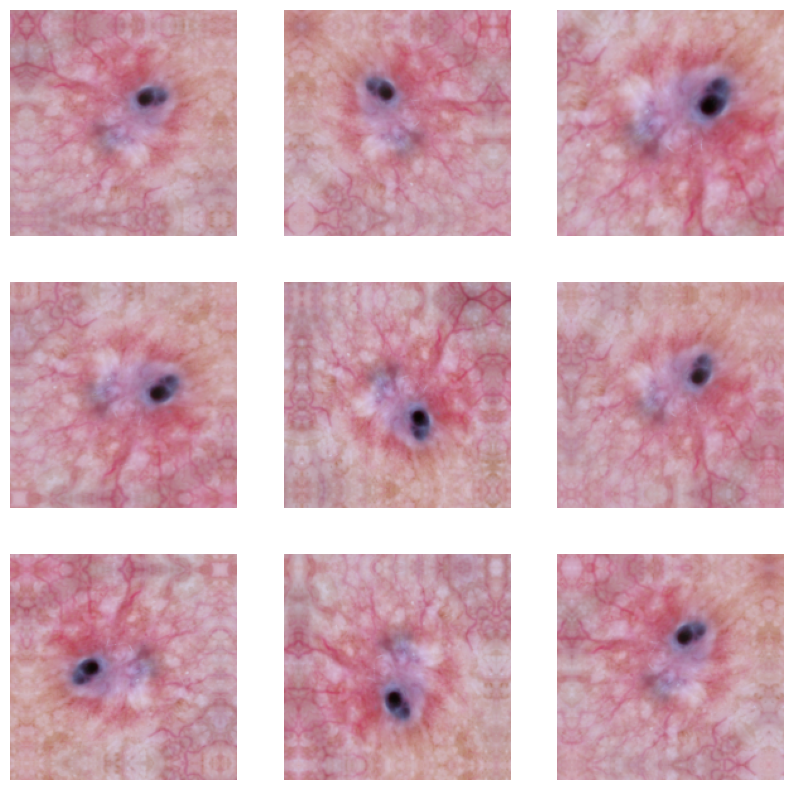

In [61]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [62]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(data_augmentation)

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 


 dropout_24 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 45, 45, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 22, 22, 64)        0         
          

### Compiling the model

In [63]:
## Your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(#optimizer='sgd',
              optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [64]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20


169/169 [==============================] - 103s 567ms/step - loss: 2.1574 - accuracy: 0.1619 - val_loss: 2.0317 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 2/20
169/169 [==============================] - 98s 582ms/step - loss: 1.8915 - accuracy: 0.2621 - val_loss: 1.8409 - val_accuracy: 0.2806 - lr: 0.0010
Epoch 3/20
169/169 [==============================] - 98s 580ms/step - loss: 1.7318 - accuracy: 0.3333 - val_loss: 1.7363 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 4/20
169/169 [==============================] - 99s 587ms/step - loss: 1.6904 - accuracy: 0.3624 - val_loss: 1.5722 - val_accuracy: 0.4105 - lr: 0.0010
Epoch 5/20
169/169 [==============================] - 93s 551ms/step - loss: 1.6159 - accuracy: 0.3761 - val_loss: 1.6055 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 6/20
169/169 [==============================] - 89s 525ms/step - loss: 1.5766 - accuracy: 0.3922 - val_loss: 1.4952 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 7/20
169/169 [==============================] - 90s 531m

### Visualizing the results

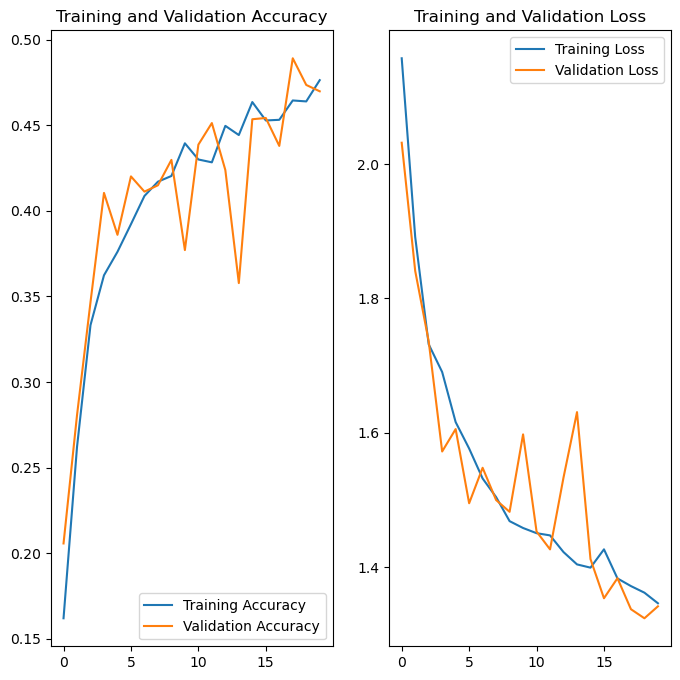

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Data Augmentation doesnt seem to be helping as the model seems to be overfitting now

The Validation Accuracy is too low and coupled with the fact that Validation Loss is too high it means that data is getting memorized and clearly causing over-fitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<function matplotlib.pyplot.show(close=None, block=None)>

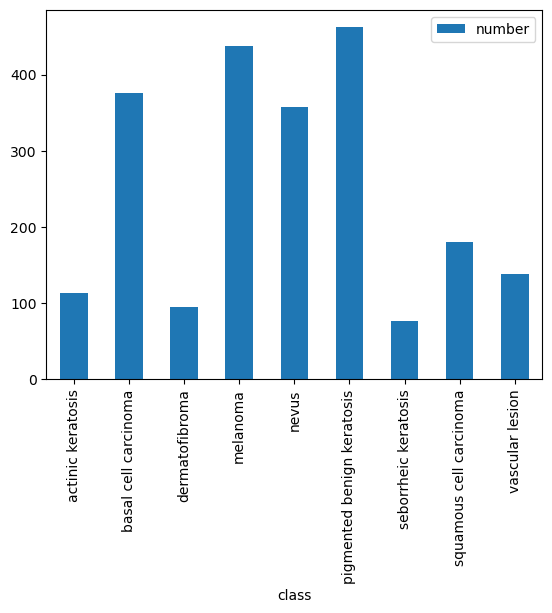

In [66]:
## Your code goes here.
class_diff=pd.DataFrame()

for i in range(len(class_names)):
  name1 = class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff = pd.concat([class_diff, pd.DataFrame({'class':[name1],'number':[number]})], ignore_index=True)

#class_diff

class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
*   seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
*   Melanoma, pigmented benign keratosis and basal cell carcinoma are the 3 highest classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [67]:
#pip install --trusted-host pypi.python.org --trusted-host pypi.org --trusted-host=files.pythonhosted.org Augmentor


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [68]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C2F1AAE190>: 100%|██████████| 500/500 [00:12<00:00, 38.47 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C345920710>: 100%|██████████| 500/500 [00:11<00:00, 42.70 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C34599DF10>: 100%|██████████| 500/500 [00:11<00:00, 43.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C34590D190>: 100%|██████████| 500/500 [00:53<00:00,  9.30 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C345061610>: 100%|██████████| 500/500 [00:51<00:00,  9.80 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C34528AC90>: 100%|██████████| 500/500 [00:11<00:00, 41.84 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C2F1A80DD0>: 100%|██████████| 500/500 [00:23<00:00, 21.07 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C34598EC10>: 100%|██████████| 500/500 [00:10<00:00, 46.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C3459187D0>: 100%|██████████| 500/500 [00:11<00:00, 43.48 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [69]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [70]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_00e5ff7b-1ede-40c3-877b-e01f8bc45479.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_124cfd7f-e4a6-4ec7-8d6f-25b246667c04.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_57490503-1462-4a77-9f1c-ce62c7fba618.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7b1453a7-a4da-413c-a7b9-f0bdf88d1d96.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7e572141-7f8f-4fce-9b16-59d312c1d45f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [71]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [72]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [73]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [74]:
new_df['Label'].value_counts()

Label
actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [75]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [76]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [77]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [78]:
## your code goes here
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [79]:
## your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [80]:
epochs = 50
## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
281/281 [==============================] - 249s 862ms/step - loss: 2.2006 - accuracy: 0.1202 - val_loss: 2.1912 - val_accuracy: 0.1331 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - 228s 808ms/step - loss: 2.0603 - accuracy: 0.1797 - val_loss: 1.9277 - val_accuracy: 0.3017 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - 229s 810ms/step - loss: 1.7008 - accuracy: 0.3303 - val_loss: 1.5269 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - 250s 884ms/step - loss: 1.5383 - accuracy: 0.3967 - val_loss: 1.4332 - val_accuracy: 0.4179 - lr: 0.0010
Epoch 5/50
281/281 [==============================] - 229s 812ms/step - loss: 1.4951 - accuracy: 0.4101 - val_loss: 1.4125 - val_accuracy: 0.4517 - lr: 0.0010
Epoch 6/50
281/281 [==============================] - 229s 812ms/step - loss: 1.4474 - accuracy: 0.4359 - val_loss: 1.3744 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 7/50
281/281 [==========================

#### **Todo:**  Visualize the model results

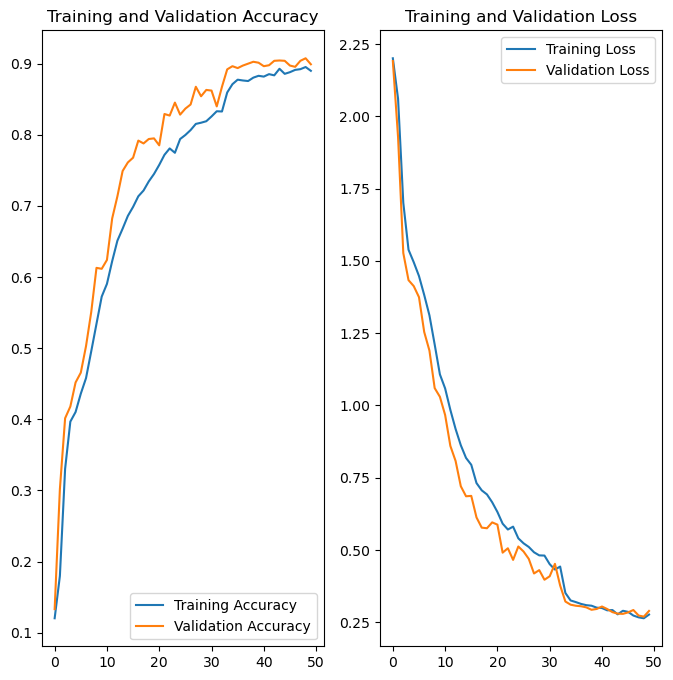

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. The training accuracy and validation accuracy are almost same thus is a good fit. The same is observed for Validation and Training Loss too.
3. The Validation accuracy is 0.89 which is good. The model is able to classify the images with 89% accuracy.

Clearly Rebalacing has helped the model in terms of increasing the Validation Accuracy and also reducing the Validation Loss